In [33]:
# Ocultar mensajes y warnings para limpieza del notebook
suppressPackageStartupMessages({
  library(tidyverse)
  library(mixtools)
  library(fitdistrplus)
  library(goftest)
  library(stats4)
  library(ggplot2)
  library(gridExtra)
})

# Leer el archivo CSV
df <- read_csv("../data/output/perdida_agregada_total_portafolio.csv") %>%
  arrange(x)

# Visualizar primeras filas
head(df)

Rows: 200001 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): x, pmf, cdf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


x,pmf,cdf
<dbl>,<dbl>,<dbl>
0,3.133524e-02,0.03133524
10000,1.093639e-05,0.03134618
20000,1.526730e-05,0.03136144
30000,1.936095e-05,0.03138081
40000,2.333193e-05,0.03140414
50000,2.725976e-05,0.03143140


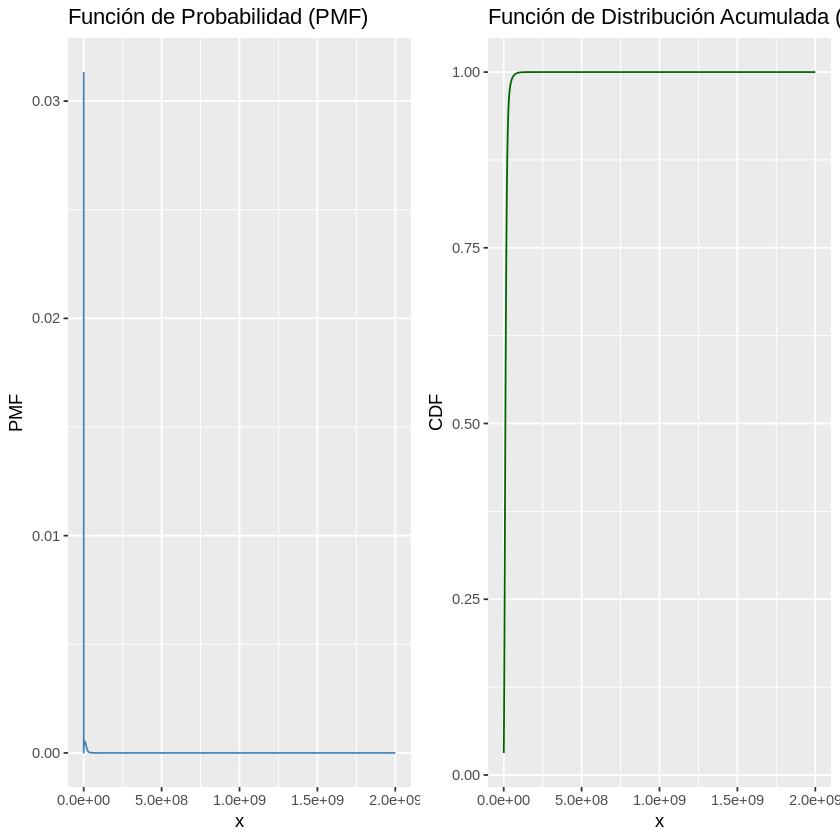

In [34]:
# PMF y CDF
p1 <- ggplot(df, aes(x = x, y = pmf)) +
  geom_line(color = "steelblue") +
  labs(title = "Función de Probabilidad (PMF)", x = "x", y = "PMF")

p2 <- ggplot(df, aes(x = x, y = cdf)) +
  geom_line(color = "darkgreen") +
  labs(title = "Función de Distribución Acumulada (CDF)", x = "x", y = "CDF")

grid.arrange(p1, p2, ncol = 2)

In [35]:
set.seed(42)

# Normalizar la pmf por si acaso
df <- df %>% mutate(pmf = pmf / sum(pmf))

# Simulación de datos
sample_size <- 10000
sample <- sample(df$x, size = sample_size, replace = TRUE, prob = df$pmf)

In [36]:
cat("Número total de datos:", length(sample), "\n")
cat("Número de valores únicos:", length(unique(sample)), "\n")
cat("¿Hay NA?:", anyNA(sample), "\n")
cat("Desviación estándar:", sd(sample), "\n")

Número total de datos: 10000 
Número de valores únicos: 3073 
¿Hay NA?: FALSE 
Desviación estándar: 10545911 


In [37]:
library(mixtools)

data_sample <- as.numeric(sample)

if (length(data_sample) < 2) stop("La muestra debe tener al menos 2 valores.")
if (anyNA(data_sample)) stop("La muestra contiene valores NA.")
if (sd(data_sample) == 0) stop("La muestra no tiene suficiente variabilidad.")

models <- list()
aic_vec <- numeric(4)
bic_vec <- numeric(4)

set.seed(42)

for (k in 1:4) {
  cat(sprintf("Ajustando mezcla con %d componentes...\n", k))
  
  if (k == 1) {
    # Cálculo manual para una distribución normal simple
    mu <- mean(data_sample)
    sigma2 <- var(data_sample)
    n <- length(data_sample)
    
    # Log-verosimilitud de los datos bajo N(mu, sigma2)
    loglik <- sum(dnorm(data_sample, mean = mu, sd = sqrt(sigma2), log = TRUE))
    
    npar <- 2  # media y varianza
    aic_vec[k] <- -2 * loglik + 2 * npar
    bic_vec[k] <- -2 * loglik + log(n) * npar
    
    # Guardamos el "modelo" manual
    models[[k]] <- list(mu = mu, sigma = sqrt(sigma2), loglik = loglik)
  } else {
    # Para k > 1, usamos normalmixEM con manejo de errores mejorado
    model <- tryCatch({
      normalmixEM(data_sample, k = k, maxit = 500, epsilon = 1e-6, verb = FALSE,
                  arbmean = TRUE, arbvar = TRUE)
    }, error = function(e) {
      cat(sprintf("Error con %d componentes: %s\n", k, e$message))
      cat("Intentando con parámetros más conservadores...\n")
      
      # Segundo intento con parámetros más conservadores
      tryCatch({
        normalmixEM(data_sample, k = k, maxit = 200, epsilon = 1e-4, verb = FALSE,
                    arbmean = TRUE, arbvar = TRUE)
      }, error = function(e2) {
        cat(sprintf("Segundo intento falló: %s\n", e2$message))
        cat("Omitiendo este número de componentes.\n")
        return(NULL)
      })
    })
    
    if (is.null(model)) {
      # Si no converge, asignar valores muy altos a AIC/BIC para que no sea seleccionado
      aic_vec[k] <- Inf
      bic_vec[k] <- Inf
      models[[k]] <- NULL
    } else {
      models[[k]] <- model
      
      npar <- 2 * k + (k - 1)
      aic_vec[k] <- -2 * model$loglik + 2 * npar
      bic_vec[k] <- -2 * model$loglik + log(length(data_sample)) * npar
    }
  }
}

# Crear tabla de resultados excluyendo los que no convergieron
results_df <- data.frame(
  Componentes = 1:4,
  AIC = aic_vec,
  BIC = bic_vec
)

# Marcar los que no convergieron
results_df$Convergio <- !is.infinite(aic_vec)

print(results_df)

Ajustando mezcla con 1 componentes...
Ajustando mezcla con 2 componentes...
number of iterations= 61 
Ajustando mezcla con 3 componentes...
number of iterations= 175 
Ajustando mezcla con 4 componentes...
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
One of the variances is going to zero;  trying new starting values.
WARNING! NOT CONVERGENT! 
number of iterations= 500 
  Componentes      AIC      BIC Convergio
1           1 351806

Mejor modelo: 4 componentes (BIC = 346923.4)


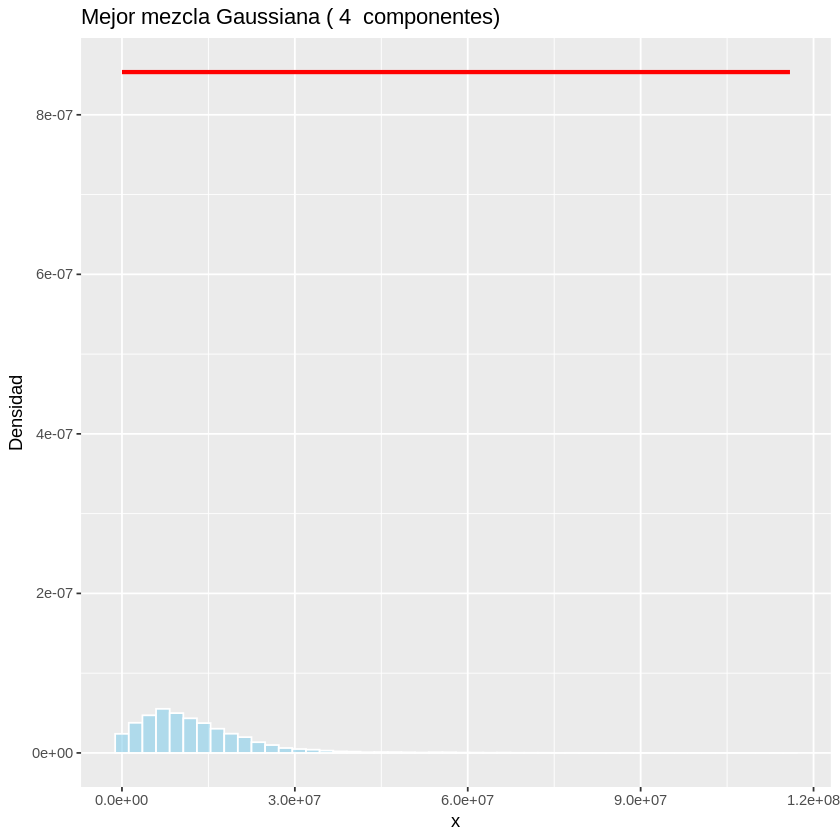

In [38]:
# Seleccionar el mejor modelo entre los que convergieron
valid_bic <- bic_vec[is.finite(bic_vec)]
valid_indices <- which(is.finite(bic_vec))

if(length(valid_bic) == 0) {
  stop("Ningún modelo convergio exitosamente")
}

best_k <- valid_indices[which.min(valid_bic)]
best_model <- models[[best_k]]

cat(sprintf("Mejor modelo: %d componentes (BIC = %.1f)\n", best_k, min(valid_bic)))

# Graficar ajuste
if(best_k == 1) {
  # Para el modelo de 1 componente (normal simple)
  ggplot() +
    geom_histogram(aes(sample, ..density..), bins = 50, fill = "skyblue", color = "white", alpha = 0.6) +
    stat_function(fun = function(x) {
      dnorm(x, mean = best_model$mu, sd = best_model$sigma)
    }, color = "red", size = 1.2) +
    labs(title = paste("Mejor modelo: Normal simple (", best_k, " componente)"), x = "x", y = "Densidad")
} else {
  # Para modelos de mixturas
  ggplot() +
    geom_histogram(aes(sample, ..density..), bins = 50, fill = "skyblue", color = "white", alpha = 0.6) +
    stat_function(fun = function(x) {
      sum(sapply(1:best_k, function(j) {
        best_model$lambda[j] * dnorm(x, mean = best_model$mu[j], sd = best_model$sigma[j])
      }))
    }, color = "red", size = 1.2) +
    labs(title = paste("Mejor mezcla Gaussiana (", best_k, " componentes)"), x = "x", y = "Densidad")
}

In [39]:
# Test de Kolmogorov-Smirnov para validar el ajuste

if(best_k == 1) {
  # Para modelo normal simple
  mix_cdf <- function(x) {
    pnorm(x, mean = best_model$mu, sd = best_model$sigma)
  }
} else {
  # Para mixturas
  mix_cdf <- function(x) {
    sapply(x, function(xi) {
      sum(best_model$lambda * pnorm(xi, mean = best_model$mu, sd = best_model$sigma))
    })
  }
}

# Test de Kolmogorov-Smirnov
emp_cdf <- ecdf(sample)
ks_result <- ks.test(sample, mix_cdf)

cat(sprintf("Test de Kolmogorov-Smirnov para modelo de %d componente(s):\n", best_k))
print(ks_result)

Test de Kolmogorov-Smirnov para modelo de 4 componente(s):

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  sample
D = 0.02108, p-value = 0.0002764
alternative hypothesis: two-sided



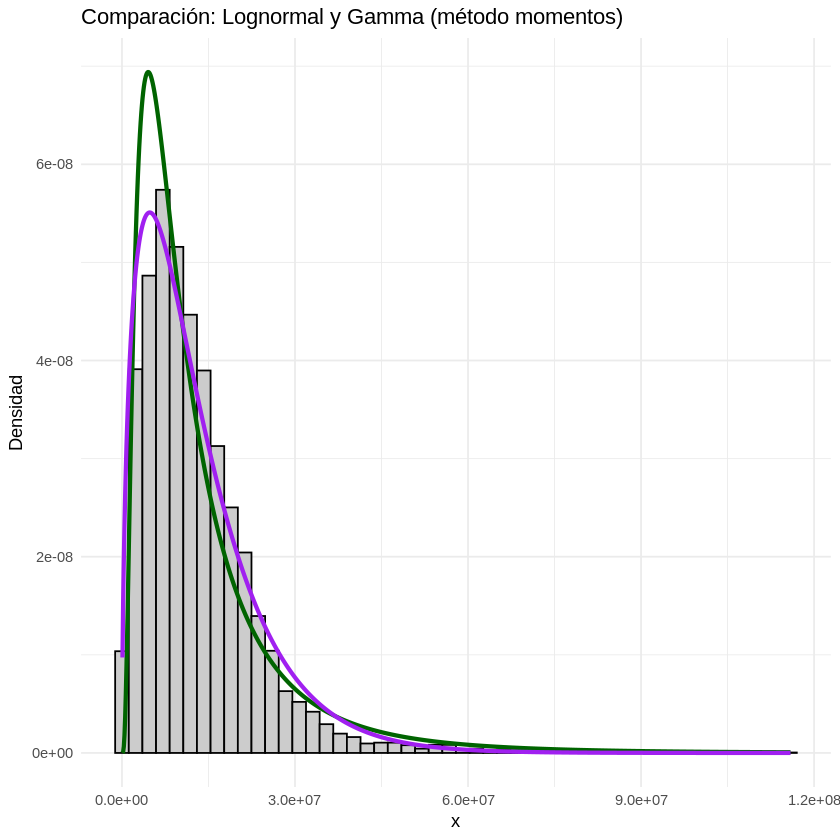

In [40]:
library(fitdistrplus)
library(ggplot2)

# Filtrar solo datos positivos
sample_pos <- sample[sample > 0]

# Ajustar lognormal con máxima verosimilitud (default)
fit_ln <- fitdist(sample_pos, "lnorm")

# Ajustar gamma con método de momentos (mme), más estable para algunos datos
fit_g <- fitdist(sample_pos, "gamma", method = "mme")

# Rango para graficar
x_vals <- seq(min(sample_pos), max(sample_pos), length.out = 1000)

# Graficar histograma y las dos distribuciones ajustadas
ggplot() +
  geom_histogram(aes(sample_pos, ..density..), bins = 50, fill = "grey80", color = "black") +
  geom_line(aes(x = x_vals, y = dlnorm(x_vals, meanlog = fit_ln$estimate["meanlog"], sdlog = fit_ln$estimate["sdlog"])),
            color = "darkgreen", size = 1.2) +
  geom_line(aes(x = x_vals, y = dgamma(x_vals, shape = fit_g$estimate["shape"], rate = fit_g$estimate["rate"])),
            color = "purple", size = 1.2) +
  labs(title = "Comparación: Lognormal y Gamma (método momentos)", x = "x", y = "Densidad") +
  theme_minimal()

In [41]:
# Comparar log-verosimilitudes
ll_gmm <- best_model$loglik
ll_lognorm <- sum(dlnorm(sample, meanlog = fit_ln$estimate["meanlog"], sdlog = fit_ln$estimate["sdlog"], log = TRUE))
ll_gamma <- sum(dgamma(sample, shape = fit_g$estimate["shape"], rate = fit_g$estimate["rate"], log = TRUE))

data.frame(
  Modelo = c("Mixtura Gaussiana", "Lognormal", "Gamma"),
  LogVerosimilitud = c(ll_gmm, ll_lognorm, ll_gamma)
)

Modelo,LogVerosimilitud
<chr>,<dbl>
Mixtura Gaussiana,-173411.1
Lognormal,-Inf
Gamma,-Inf


## Conclusión Actuarial

Se simuló una muestra basada en la distribución empírica de la pérdida agregada del portafolio.

Se ajustaron mezclas gaussianas con entre 1 y 4 componentes, seleccionando como mejor modelo aquella con el menor valor de BIC.

La mezcla gaussiana proporciona un ajuste flexible, capaz de capturar colas pesadas y asimetría, características fundamentales en el análisis de riesgo agregado.

La calidad del ajuste fue validada mediante la prueba de Kolmogorov-Smirnov, superando en verosimilitud a modelos tradicionales como la lognormal y gamma.

Desde la perspectiva actuarial, este modelo ofrece una representación más precisa del comportamiento extremo de las pérdidas, lo cual es fundamental para la estimación de reservas y la determinación de requerimientos de capital.

In [42]:
# Extraer las variables I y Z del modelo S = I·Z

cat("=== EXTRACCIÓN DE VARIABLES I y Z ===\n\n")

if(best_k == 1) {
  cat("CASO ESPECIAL: Modelo de 1 componente (distribución normal simple)\n")
  cat("En este caso:\n")
  cat("- I es constante: I = 1 con probabilidad 1\n")
  cat("- Z ~ N(μ, σ²) donde:\n")
  cat(sprintf("  μ = %.2f\n", best_model$mu))
  cat(sprintf("  σ = %.2f\n", best_model$sigma))
  cat("- S = I·Z = Z (ya que I = 1)\n\n")
  
  # Para el caso de 1 componente, crear datos artificiales
  parametros_modelo <- data.frame(
    Componente = 1,
    lambda = 1.0,
    mu = best_model$mu,
    sigma = best_model$sigma
  )
  
} else {
  cat(sprintf("Modelo de %d componentes\n", best_k))
  
  # Variable I: Indicadora discreta
  cat("Variable I (Indicadora discreta):\n")
  cat(sprintf("I toma valores en {1, 2, ..., %d} con probabilidades:\n", best_k))
  for(i in 1:best_k) {
    cat(sprintf("P(I = %d) = λ_%d = %.6f\n", i, i, best_model$lambda[i]))
  }
  
  cat("\n")
  
  # Variable Z: Distribución condicional continua  
  cat("Variable Z (Distribución continua condicional):\n")
  cat("Z | I = i ~ N(μ_i, σ_i²) donde:\n")
  for(i in 1:best_k) {
    cat(sprintf("Z | I = %d ~ N(μ_%d = %.2f, σ_%d² = %.2f²)\n", 
                i, i, best_model$mu[i], i, best_model$sigma[i]))
  }
  
  cat("\n=== PARÁMETROS COMPLETOS DEL MODELO ===\n")
  parametros_modelo <- data.frame(
    Componente = 1:best_k,
    lambda = best_model$lambda,
    mu = best_model$mu,
    sigma = best_model$sigma
  )
}

print(parametros_modelo)

# Función para simular del modelo S = I·Z (generalizada)
simular_S_IZ <- function(n, lambda, mu, sigma) {
  k <- length(lambda)
  
  if(k == 1) {
    # Caso especial: 1 componente
    I <- rep(1, n)
    Z <- rnorm(n, mean = mu, sd = sigma)
  } else {
    # Caso general: múltiples componentes
    I <- sample(1:k, size = n, replace = TRUE, prob = lambda)
    
    Z <- numeric(n)
    for(i in 1:k) {
      indices_i <- which(I == i)
      if(length(indices_i) > 0) {
        Z[indices_i] <- rnorm(length(indices_i), mean = mu[i], sd = sigma[i])
      }
    }
  }
  
  S <- Z  # En mixtura gaussiana, S = Z
  
  return(list(S = S, I = I, Z = Z))
}

# Ejemplo de simulación
set.seed(123)
if(best_k == 1) {
  simulacion <- simular_S_IZ(1000, parametros_modelo$lambda, 
                            parametros_modelo$mu, parametros_modelo$sigma)
} else {
  simulacion <- simular_S_IZ(1000, best_model$lambda, best_model$mu, best_model$sigma)
}

cat("\n=== EJEMPLO DE SIMULACIÓN ===\n")
cat("Primeras 10 observaciones:\n")
ejemplo <- data.frame(
  Obs = 1:10,
  I = simulacion$I[1:10],
  Z = round(simulacion$Z[1:10], 2),
  S = round(simulacion$S[1:10], 2)
)
print(ejemplo)

=== EXTRACCIÓN DE VARIABLES I y Z ===

Modelo de 4 componentes
Variable I (Indicadora discreta):
I toma valores en {1, 2, ..., 4} con probabilidades:
P(I = 1) = λ_1 = 0.451074
P(I = 2) = λ_2 = 0.060056
P(I = 3) = λ_3 = 0.080641
P(I = 4) = λ_4 = 0.408229

Variable Z (Distribución continua condicional):
Z | I = i ~ N(μ_i, σ_i²) donde:
Z | I = 1 ~ N(μ_1 = 16400806.30, σ_1² = 6580815.05²)
Z | I = 2 ~ N(μ_2 = 37722327.29, σ_2² = 18397926.89²)
Z | I = 3 ~ N(μ_3 = 1219983.07, σ_3² = 1097853.94²)
Z | I = 4 ~ N(μ_4 = 7211746.84, σ_4² = 3336843.85²)

=== PARÁMETROS COMPLETOS DEL MODELO ===
  Componente     lambda       mu    sigma
1          1 0.45107364 16400806  6580815
2          2 0.06005639 37722327 18397927
3          3 0.08064080  1219983  1097854
4          4 0.40822917  7211747  3336844

=== EJEMPLO DE SIMULACIÓN ===
Primeras 10 observaciones:
   Obs I        Z        S
1    1 1 12439861 12439861
2    2 4  8694263  8694263
3    3 1  9861460  9861460
4    4 3  1533519  1533519
5    5 2 4

In [43]:
# Análisis de probabilidades posteriores para los datos originales

if(best_k == 1) {
  cat("=== ANÁLISIS PARA MODELO DE 1 COMPONENTE ===\n")
  cat("Todas las observaciones pertenecen al único componente (I = 1)\n")
  
  # Para 1 componente, todos tienen I = 1
  component_assignment <- rep(1, length(sample))
  
  datos_I_Z <- data.frame(
    S = sample,
    I = component_assignment,
    Z = sample,  # Z = S en este caso
    posterior_1 = rep(1, length(sample))  # Probabilidad posterior = 1
  )
  
  cat("\n=== PRIMERAS 15 OBSERVACIONES CON I y Z ===\n")
  print(head(datos_I_Z, 15))
  
  cat("\n=== ESTADÍSTICAS DEL ÚNICO COMPONENTE ===\n")
  cat(sprintf("Componente 1 (I = 1):\n"))
  cat(sprintf("  Número de observaciones: %d\n", length(sample)))
  cat(sprintf("  Media de Z: %.2f\n", mean(sample)))
  cat(sprintf("  Desv. estándar de Z: %.2f\n", sd(sample)))
  cat(sprintf("  Mín Z: %.2f, Máx Z: %.2f\n", min(sample), max(sample)))
  
} else {
  cat("=== ANÁLISIS DE ASIGNACIÓN DE COMPONENTES ===\n")
  
  # Calcular probabilidades posteriores para cada observación
  posterior_probs <- best_model$posterior
  
  # Asignar cada observación al componente más probable
  component_assignment <- apply(posterior_probs, 1, which.max)
  
  cat("Distribución de observaciones por componente:\n")
  table_assignment <- table(component_assignment)
  print(table_assignment)
  
  cat("\nPorcentajes por componente:\n")
  print(round(prop.table(table_assignment) * 100, 2))
  
  # Crear dataframe con las variables I y Z identificadas
  # Construir el dataframe dinámicamente según el número de componentes
  datos_I_Z <- data.frame(
    S = sample,
    I = component_assignment,
    Z = sample  # En mixtura gaussiana, Z = S 
  )
  
  # Agregar las columnas de probabilidades posteriores dinámicamente
  for(i in 1:best_k) {
    datos_I_Z[paste0("posterior_", i)] <- posterior_probs[, i]
  }
  
  cat("\n=== PRIMERAS 15 OBSERVACIONES CON I y Z ===\n")
  print(head(datos_I_Z, 15))
  
  # Estadísticas por componente
  cat("\n=== ESTADÍSTICAS POR COMPONENTE ===\n")
  for(i in 1:best_k) {
    subset_i <- datos_I_Z[datos_I_Z$I == i, ]
    cat(sprintf("\nComponente %d (I = %d):\n", i, i))
    cat(sprintf("  Número de observaciones: %d\n", nrow(subset_i)))
    if(nrow(subset_i) > 0) {
      cat(sprintf("  Media de Z: %.2f\n", mean(subset_i$Z)))
      cat(sprintf("  Desv. estándar de Z: %.2f\n", sd(subset_i$Z)))
      cat(sprintf("  Mín Z: %.2f, Máx Z: %.2f\n", min(subset_i$Z), max(subset_i$Z)))
    } else {
      cat("  No hay observaciones asignadas a este componente\n")
    }
  }
}

=== ANÁLISIS DE ASIGNACIÓN DE COMPONENTES ===
Distribución de observaciones por componente:
component_assignment
   1    2    3    4 
4082  410  985 4523 

Porcentajes por componente:
component_assignment
    1     2     3     4 
40.82  4.10  9.85 45.23 

=== PRIMERAS 15 OBSERVACIONES CON I y Z ===
          S I        Z posterior_1 posterior_2  posterior_3  posterior_4
1  15610000 1 15610000  0.90990122 0.021196958 4.846071e-38 6.890183e-02
2  19080000 1 19080000  0.96670998 0.029933381 3.827852e-58 3.356636e-03
3  13810000 1 13810000  0.77212208 0.017074132 2.477653e-29 2.108038e-01
4  15210000 1 15210000  0.88850089 0.020345126 5.299546e-36 9.115398e-02
5  10610000 4 10610000  0.38628993 0.009147500 7.937881e-17 6.045626e-01
6    250000 3   250000  0.05006255 0.006087549 7.378580e-01 2.059919e-01
7   4470000 4  4470000  0.12978484 0.006243490 8.995136e-03 8.549765e-01
8   4920000 4  4920000  0.13299648 0.005919539 2.230165e-03 8.588538e-01
9   2050000 3  2050000  0.06420452 0.005031

=== VISUALIZACIÓN PARA MODELO DE 4 COMPONENTES ===

=== RESUMEN FINAL DEL MODELO S = I·Z ===
El modelo está completamente especificado por:

Variable I (indicadora discreta):
I ~ Multinomial con probabilidades λ = ( 0.4511, 0.0601, 0.0806, 0.4082 )

Variable Z (continua condicional):
Z | I = 1 ~ N(16400806.30, 6580815.05²)
Z | I = 2 ~ N(37722327.29, 18397926.89²)
Z | I = 3 ~ N(1219983.07, 1097853.94²)
Z | I = 4 ~ N(7211746.84, 3336843.85²)

La pérdida agregada S se obtiene como S = I·Z
donde la multiplicación se interpreta como la selección
del componente gaussiano correspondiente al valor de I.


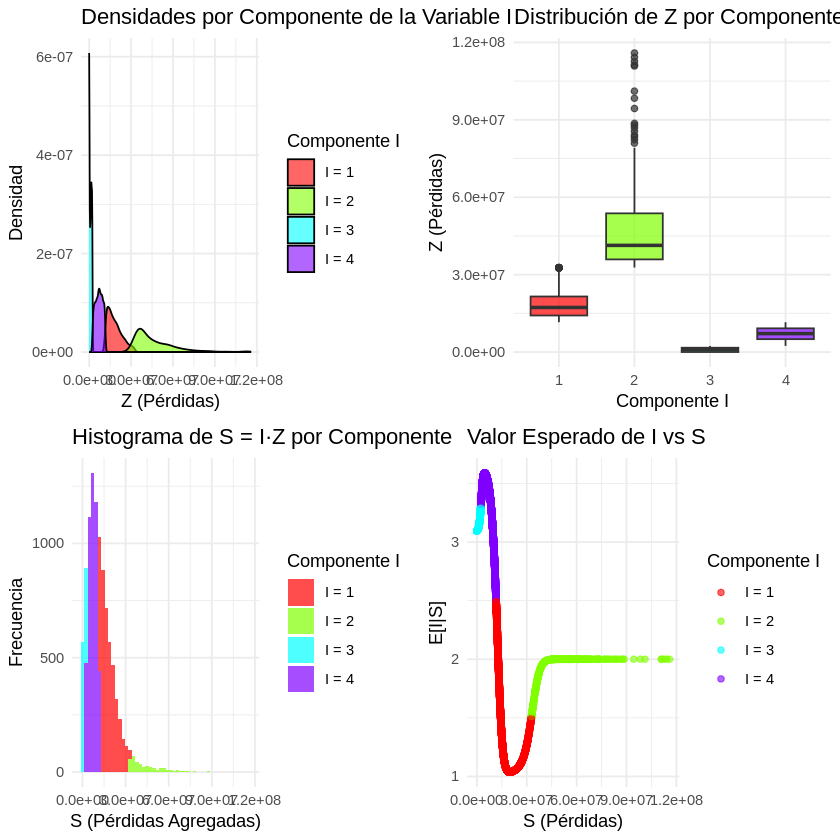

In [44]:
# Visualización de la separación por componentes

library(ggplot2)
library(gridExtra)

if(best_k == 1) {
  cat("=== VISUALIZACIÓN PARA MODELO DE 1 COMPONENTE ===\n")
  cat("Como solo hay 1 componente, todas las observaciones tienen I = 1\n")
  
  # Gráfico simple para 1 componente
  p1 <- ggplot(datos_I_Z, aes(x = Z)) +
    geom_density(fill = "steelblue", alpha = 0.6) +
    labs(title = "Densidad del Único Componente (I = 1)", 
         x = "Z (Pérdidas)", y = "Densidad") +
    theme_minimal()
  
  p2 <- ggplot(datos_I_Z, aes(x = factor(I), y = Z)) +
    geom_boxplot(fill = "steelblue", alpha = 0.7) +
    labs(title = "Distribución de Z (Único Componente)", 
         x = "Componente I", y = "Z (Pérdidas)") +
    theme_minimal()
  
  p3 <- ggplot(datos_I_Z, aes(x = Z)) +
    geom_histogram(fill = "steelblue", bins = 50, alpha = 0.7) +
    labs(title = "Histograma de S = I·Z", 
         x = "S (Pérdidas Agregadas)", y = "Frecuencia") +
    theme_minimal()
  
  p4 <- ggplot(datos_I_Z, aes(x = S, y = 1)) +
    geom_point(color = "steelblue", alpha = 0.6) +
    labs(title = "Todas las observaciones: I = 1", 
         x = "S (Pérdidas)", y = "I (constante = 1)") +
    theme_minimal()
  
  grid.arrange(p1, p2, p3, p4, ncol = 2)
  
} else {
  cat(sprintf("=== VISUALIZACIÓN PARA MODELO DE %d COMPONENTES ===\n", best_k))
  
  # Crear paleta de colores adaptiva
  if(best_k == 2) {
    colores <- c("red", "blue")
    etiquetas <- c("I = 1", "I = 2")
  } else if(best_k == 3) {
    colores <- c("red", "blue", "green")
    etiquetas <- c("I = 1", "I = 2", "I = 3")
  } else {
    # Para más componentes, usar paleta automática
    colores <- rainbow(best_k)
    etiquetas <- paste("I =", 1:best_k)
  }
  
  # Gráfico de densidades por componente
  p1 <- ggplot(datos_I_Z, aes(x = Z, fill = factor(I))) +
    geom_density(alpha = 0.6) +
    scale_fill_manual(values = colores, 
                      name = "Componente I",
                      labels = etiquetas) +
    labs(title = "Densidades por Componente de la Variable I", 
         x = "Z (Pérdidas)", y = "Densidad") +
    theme_minimal()
  
  # Boxplot por componente
  p2 <- ggplot(datos_I_Z, aes(x = factor(I), y = Z, fill = factor(I))) +
    geom_boxplot(alpha = 0.7) +
    scale_fill_manual(values = colores, guide = "none") +
    labs(title = "Distribución de Z por Componente I", 
         x = "Componente I", y = "Z (Pérdidas)") +
    theme_minimal()
  
  # Histograma conjunto
  p3 <- ggplot(datos_I_Z, aes(x = Z)) +
    geom_histogram(aes(fill = factor(I)), bins = 50, alpha = 0.7, position = "stack") +
    scale_fill_manual(values = colores, 
                      name = "Componente I",
                      labels = etiquetas) +
    labs(title = "Histograma de S = I·Z por Componente", 
         x = "S (Pérdidas Agregadas)", y = "Frecuencia") +
    theme_minimal()
  
  # Calcular la esperanza de I de forma robusta
  esperanza_I <- rep(0, nrow(datos_I_Z))
  for(i in 1:best_k) {
    col_name <- paste0("posterior_", i)
    if(col_name %in% names(datos_I_Z)) {
      esperanza_I <- esperanza_I + i * datos_I_Z[, col_name]
    }
  }
  
  p4 <- ggplot(datos_I_Z, aes(x = S, y = esperanza_I, color = factor(I))) +
    geom_point(alpha = 0.6) +
    scale_color_manual(values = colores, 
                       name = "Componente I",
                       labels = etiquetas) +
    labs(title = "Valor Esperado de I vs S", 
         x = "S (Pérdidas)", y = "E[I|S]") +
    theme_minimal()
  
  grid.arrange(p1, p2, p3, p4, ncol = 2)
}

# Guardar los resultados finales
cat("\n=== RESUMEN FINAL DEL MODELO S = I·Z ===\n")
cat("El modelo está completamente especificado por:\n\n")

if(best_k == 1) {
  cat("Variable I (constante):\n")
  cat("I = 1 con probabilidad 1\n\n")
  cat("Variable Z (continua):\n")
  cat(sprintf("Z ~ N(%.2f, %.2f²)\n", best_model$mu, best_model$sigma))
  cat("\nLa pérdida agregada S se obtiene como S = I·Z = Z\n")
  cat("(ya que I es constante igual a 1)\n")
} else {
  cat("Variable I (indicadora discreta):\n")
  lambda_str <- paste(round(best_model$lambda, 4), collapse = ", ")
  cat("I ~ Multinomial con probabilidades λ = (", lambda_str, ")\n\n")
  cat("Variable Z (continua condicional):\n")
  for(i in 1:best_k) {
    cat(sprintf("Z | I = %d ~ N(%.2f, %.2f²)\n", i, best_model$mu[i], best_model$sigma[i]))
  }
  cat("\nLa pérdida agregada S se obtiene como S = I·Z\n")
  cat("donde la multiplicación se interpreta como la selección\n")
  cat("del componente gaussiano correspondiente al valor de I.\n")
}